In [1]:
# Adjust the import according to what you installed
import gymnasium as gym

# Attempt to create and reset an environment
env = gym.make('CartPole-v1')  # Ensure 'CartPole-v1' is available in the installed package
env.reset()
print("Environment is ready.")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools

from stable_baselines3 import PPO
from sb3_contrib import TRPO
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecMonitor

import sys
sys.path.append("../")

from mbt_gym.agents.BaselineAgents import CarteaJaimungalMmAgent
from mbt_gym.agents.BaselineAgents import AvellanedaStoikovAgent
from mbt_gym.gym.helpers.generate_trajectory import generate_trajectory
from mbt_gym.gym.StableBaselinesTradingEnvironment import StableBaselinesTradingEnvironment
from mbt_gym.gym.TradingEnvironment import TradingEnvironment
from mbt_gym.gym.wrappers import *
from mbt_gym.rewards.RewardFunctions import PnL, CjMmCriterion, RunningInventoryPenalty
from mbt_gym.stochastic_processes.midprice_models import BrownianMotionMidpriceModel
from mbt_gym.stochastic_processes.arrival_models import PoissonArrivalModel, HawkesArrivalModel
from mbt_gym.stochastic_processes.fill_probability_models import ExponentialFillFunction
from mbt_gym.gym.ModelDynamics import LimitOrderModelDynamics

from mbt_gym.gym.helpers.plotting import generate_trajectory, generate_results_table_and_hist, plot_trajectory, plot_stable_baselines_actions


import importlib

Environment is ready.


In [2]:
terminal_time = 1.0
arrival_rate = 10.0
n_steps = int(20 * terminal_time * arrival_rate)
phi = 0.5
alpha = 0.001

In [16]:
def get_Hk_OF(num_trajectories:int = 1):
    fill_exponent = 1
    sigma = 2
    initial_inventory = (0,1) # 0$ in cash and 1$ dollars in stock
    initial_price = 100
    step_size = 1/n_steps
    timestamps = np.linspace(0, terminal_time, n_steps + 1)
    midprice_model = BrownianMotionMidpriceModel(volatility=sigma, step_size=1/n_steps,
                                                num_trajectories=num_trajectories)
    
    # I should maybe specify the baseline rate
    arrival_model = HawkesArrivalModel(step_size=1/n_steps, 
                                        num_trajectories=num_trajectories)
    fill_probability_model = ExponentialFillFunction(fill_exponent=fill_exponent, 
                                                    step_size=1/n_steps,
                                                    num_trajectories=num_trajectories)
    LOtrader = LimitOrderModelDynamics(midprice_model = midprice_model, arrival_model = arrival_model, 
                                fill_probability_model = fill_probability_model,
                                num_trajectories = num_trajectories)
    reward_function = RunningInventoryPenalty(per_step_inventory_aversion = phi, terminal_inventory_aversion = alpha)

    env_params = dict(terminal_time=terminal_time, 
                      n_steps=n_steps,
                      initial_inventory = initial_inventory,
                      model_dynamics = LOtrader,
                      max_inventory=n_steps,
                      normalise_action_space = False,
                      normalise_observation_space = False,
                      reward_function = reward_function,
                      num_trajectories=num_trajectories)
    return TradingEnvironment(**env_params)

In [17]:
num_trajectories = 1000
env = ReduceStateSizeWrapper(get_Hk_OF(num_trajectories))
sb_env = StableBaselinesTradingEnvironment(trading_env=env)

# Monitor sb_env
sb_env = VecMonitor(sb_env)
# Add directory for tensorboard logging and best model
tensorboard_logdir = "./ppo_tensorboard/"
best_model_path = "./SB_models/PPO-best-CJ"

d:\Anaconda3\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.num_trajectories to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_trajectories` for environment variables or `env.get_wrapper_attr('num_trajectories')` that will search the reminding wrappers.
  logger.warn(
d:\Anaconda3\lib\site-packages\stable_baselines3\common\vec_env\base_vec_env.py:77: UserWarning: The `render_mode` attribute is not defined in your environment. It will be set to None.
  warnings.warn("The `render_mode` attribute is not defined in your environment. It will be set to None.")


In [8]:
# Define lists of values for PPO parameters
learning_rate_list = [0.0001, 0.001, 0.01] # Learning rate
gamma_list = [0.95, 0.99] # gamma: Discount factor
gae_lambda_list = [0.9, 0.95, 1.0] # gae_lambda: Factor for trade-off of bias vs variance for Generalized Advantage Estimator
normalize_advantage_list = [True, False] # Whether or not to normalize the advantage

policy_kwargs = dict(net_arch=[dict(pi=[256, 256], vf=[256, 256])])

for learning_rate, gamma, gae_lambda, normalize_advantage in itertools.product(
        learning_rate_list, gamma_list, gae_lambda_list, normalize_advantage_list):

        print(f'Using learning rate: {learning_rate}, \
                gamma: {gamma}, \
                gae_lambda: {gae_lambda}, \
                Using normalized advantage: {normalize_advantage}')

        PPO_params = {"policy":'MlpPolicy', "env": sb_env, "verbose":1, 
                        "policy_kwargs":policy_kwargs, 
                        "tensorboard_log":tensorboard_logdir,
                        "n_epochs":3,
                        "batch_size": int(n_steps * num_trajectories / 10), 
                        "n_steps": int(n_steps),
                        ### Parameters in lists
                        "learning_rate": learning_rate, 
                        "gamma": gamma,
                        "gae_lambda": gae_lambda,
                        "normalize_advantage": normalize_advantage}

        model = PPO(**PPO_params, device="cpu")

        callback_params = dict(eval_env=sb_env, n_eval_episodes = 2048, #200 before  (n_eval_episodes)
                                best_model_save_path = best_model_path, 
                                deterministic=True)

        callback = EvalCallback(**callback_params)
        
        model.learn(total_timesteps = 10_000_000)  # Increase number of training timesteps according to computing resources
        model.save(f'./models/PPO_lr{learning_rate}_gamma{gamma}_gae_lambda{gae_lambda}_NormalizedAdvantage{normalize_advantage}')

Using learning rate: 0.0001,                 gamma: 0.95,                 gae_lambda: 0.9,                 Using normalized advantage: True
Using cpu device
Logging to ./ppo_tensorboard/PPO_2


d:\Anaconda3\lib\site-packages\stable_baselines3\common\policies.py:486: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -56.5    |
| time/              |          |
|    fps             | 85750    |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 200000   |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 200          |
|    ep_rew_mean          | -39.1        |
| time/                   |              |
|    fps                  | 23591        |
|    iterations           | 2            |
|    time_elapsed         | 16           |
|    total_timesteps      | 400000       |
| train/                  |              |
|    approx_kl            | 0.0019121658 |
|    clip_fraction        | 0.00693      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    explained_variance   | -0.00915     |
|    learning_r

In [ ]:
for learning_rate, gamma, gae_lambda, normalize_advantage in itertools.product(
        learning_rate_list, gamma_list, gae_lambda_list, normalize_advantage_list):

        print(f'Using learning rate: {learning_rate}, gamma: {gamma}, gae_lambda: {gae_lambda}, Using normalized advantage: {normalize_advantage}')

        TRPO_params = {"policy":'MlpPolicy', "env": sb_env, "verbose":1, 
                        "policy_kwargs":policy_kwargs, 
                        "tensorboard_log":tensorboard_logdir,
                        #"n_epochs":3,
                        "batch_size": int(n_steps * num_trajectories / 10), 
                        "n_steps": int(n_steps),
                        ### Parameters in lists
                        "learning_rate": learning_rate, 
                        "gamma": gamma,
                        "gae_lambda": gae_lambda,
                        "normalize_advantage": normalize_advantage}

        model = TRPO(**TRPO_params, device="cpu")

        callback_params = dict(eval_env=sb_env, n_eval_episodes = 2048, #200 before  (n_eval_episodes)
                                best_model_save_path = best_model_path, 
                                deterministic=True)

        callback = EvalCallback(**callback_params)
        
        model.learn(total_timesteps = 10_000_000)  # Increase number of training timesteps according to computing resources
        model.save(f'./models/TRPO_lr{learning_rate}_gamma{gamma}_gae_lambda{gae_lambda}_NormalizedAdvantage{normalize_advantage}')

In [ ]:
# model.learn(total_timesteps = 10_000_000)  # Increase number of training timesteps according to computing resources

Logging to ./tensorboard/PPO-learning-CJ/PPO_14
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -31.8    |
| time/              |          |
|    fps             | 317962   |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 200000   |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 200          |
|    ep_rew_mean          | -45.8        |
| time/                   |              |
|    fps                  | 111564       |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 400000       |
| train/                  |              |
|    approx_kl            | 0.0018091698 |
|    clip_fraction        | 0.00672      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.84        |
|    expla

### Backtest on historical data

In [ ]:
# TODO: What is the format of historical data? How to run testing on real data?


### Analysis and Visualization

In [ ]:
ppo_agent.get_action

(2,)


c:\Users\jean-\OneDrive\Bureau\MA2\Reinforcement Learning\Reinforcement-Learning\.venv3108\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.num_trajectories to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_trajectories` for environment variables or `env.get_wrapper_attr('num_trajectories')` that will search the reminding wrappers.
  logger.warn(
c:\Users\jean-\OneDrive\Bureau\MA2\Reinforcement Learning\Reinforcement-Learning\.venv3108\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.n_steps to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.n_steps` for environment variables or `env.get_wrapper_attr('n_steps')` that will search the reminding wrappers.
  logger.warn(
c:\Users\jean-\OneDrive\Bureau\MA2\Reinforcement Learning\Reinforcement-Learning\.venv3108\lib\site-packages\gymnasium\core.py:311: UserW

          Mean spread   Mean PnL   Std PnL Mean terminal inventory  \
Inventory     2.64834  16.325301  6.421824                     0.0   

          Std terminal inventory  
Inventory                    0.0  


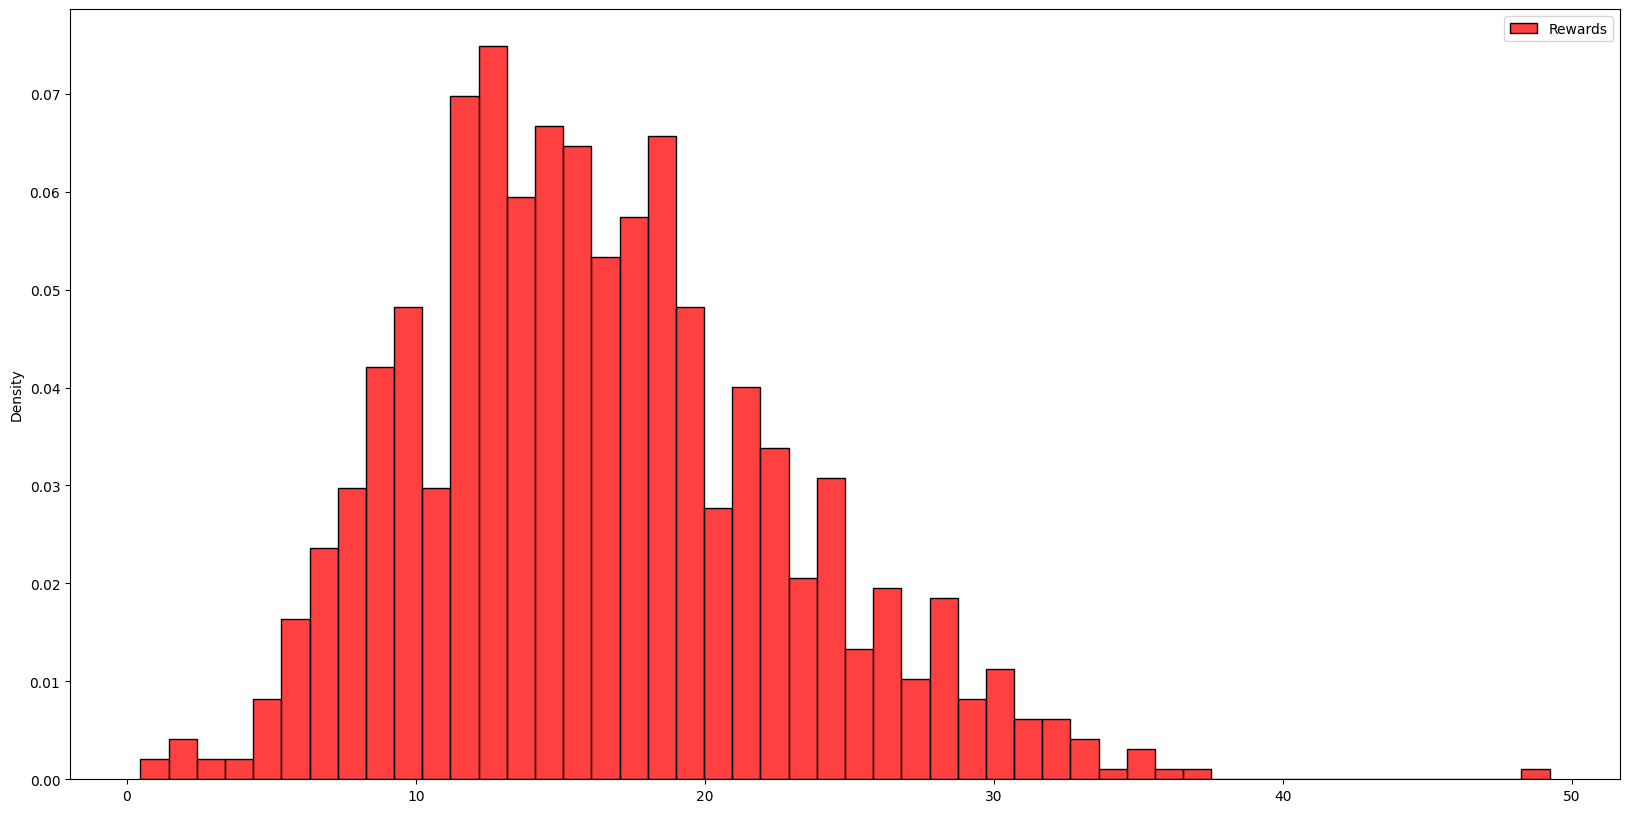

In [ ]:
from mbt_gym.agents.SbAgent import SbAgent

ppo_agent = SbAgent(model)

results, fig, total_rewards = generate_results_table_and_hist(vec_env= sb_env ,agent= ppo_agent)

print(results) 

fig

In [ ]:
print(total_rewards.mean())

16.32530065592538


1000 trajectories with 100 steps

We will plot the mean rewards of the 1000 trajectories as a function of the number of steps.

(2,)


c:\Users\jean-\OneDrive\Bureau\MA2\Reinforcement Learning\Reinforcement-Learning\.venv3108\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.num_trajectories to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_trajectories` for environment variables or `env.get_wrapper_attr('num_trajectories')` that will search the reminding wrappers.
  logger.warn(
c:\Users\jean-\OneDrive\Bureau\MA2\Reinforcement Learning\Reinforcement-Learning\.venv3108\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.n_steps to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.n_steps` for environment variables or `env.get_wrapper_attr('n_steps')` that will search the reminding wrappers.
  logger.warn(


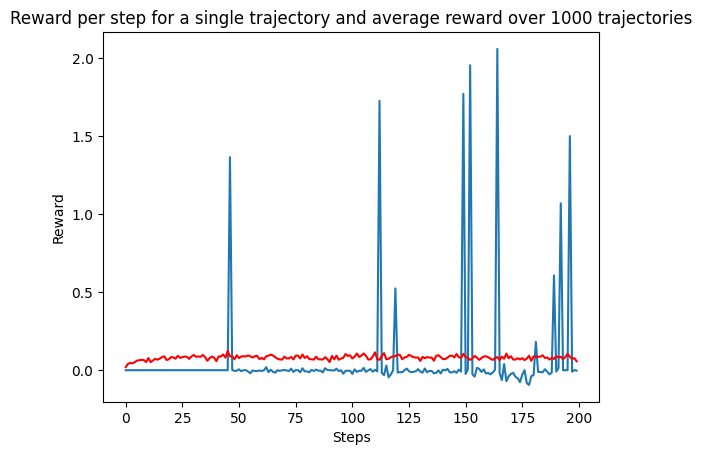

Average reward cumulated over 200 steps:  16.085743915676506


In [ ]:
observations, actions, rewards = generate_trajectory(sb_env, ppo_agent)

rew_1 = rewards[5].reshape(-1)

rew_average = rewards.mean(axis=0).reshape(-1)

plt.plot(rew_1)

plt.plot(rew_average, color = 'red')
plt.ylabel("Reward")
plt.xlabel("Steps")
plt.title("Reward per step for a single trajectory and average reward over 1000 trajectories")
plt.show()

print("Average reward cumulated over 200 steps: ", rew_average.sum())

I could incorporate the Sharpe Ratio with the following formula,

$$
R_{t+1} = \frac{P_{t+1} - P_t + D_{t+1}}{P_t}
$$

Account the produce of buying and selling the assest as the dividend yield

**INCORPORATE**

- Sharpe Ratio
- Is the investor constrainted, can he short sell? If no, it will be interesting to see the effect of the constraint depending on the volatility of the environment

In [ ]:
observations, actions, rewards = generate_trajectory(sb_env, ppo_agent, seed = 1)

rewards = np.squeeze(rewards, axis=1)

(2,)


c:\Users\jean-\OneDrive\Bureau\MA2\Reinforcement Learning\Reinforcement-Learning\.venv3108\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(


Plot the midprice bid half spread and midprice ask half spread

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

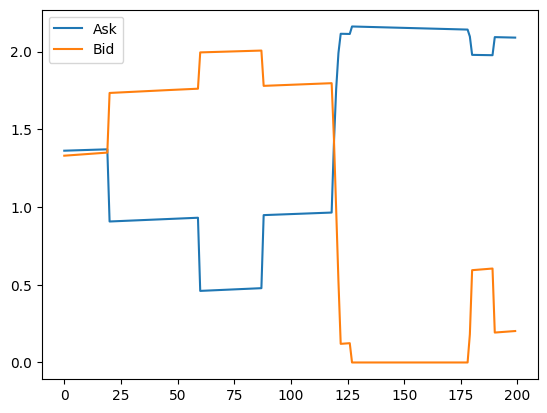

In [ ]:
plt.plot(actions[200,1,:], label = "Ask")
plt.plot(actions[200,0,:], label= "Bid")

plt.legend()
plt.plot

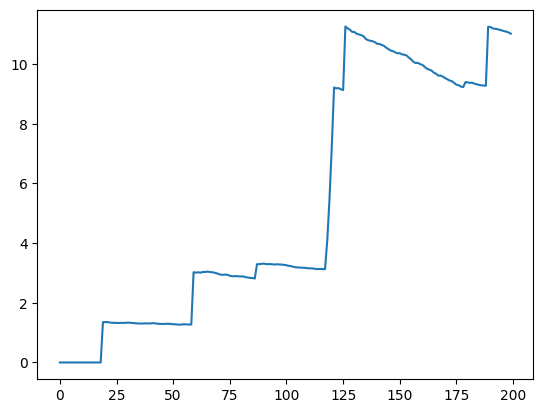

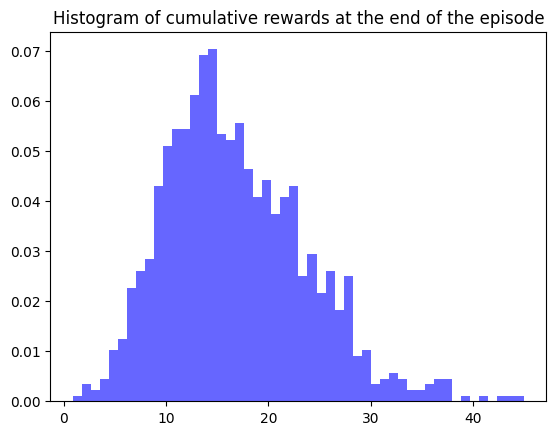

In [ ]:
cum_rewards = np.cumsum(rewards, axis=-1)


plt.plot(cum_rewards[200])
plt.show()

plt.hist(cum_rewards[:,-1], bins = 50, density = True, alpha = 0.6, color = 'b')
plt.title("Histogram of cumulative rewards at the end of the episode")
plt.show()

That is the cash index of the market maker, I dont know why but it always finish with 0

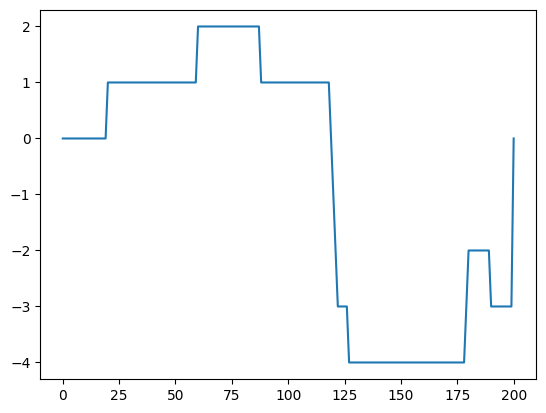

In [ ]:
plt.plot(observations[200,0,:])

There is an issue, according to the following result we always finish with no inventory and it increase linearly for all trajectories.

I think there is an issue with the code, the following plot cannot be the inventory index but the time index.

(1000, 201)


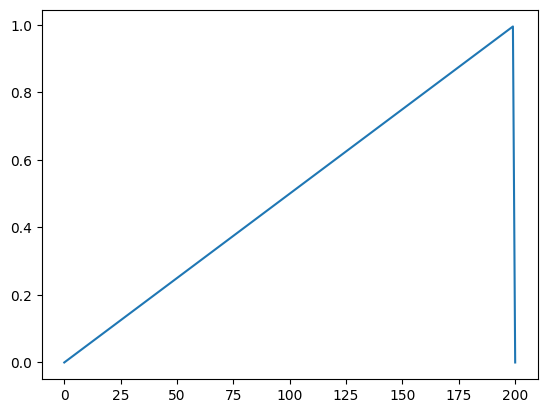

In [ ]:
print(observations[:, INVENTORY_INDEX, :].shape)

plt.plot(observations[200, INVENTORY_INDEX, :])

In [ ]:
x, _, _ = generate_trajectory(sb_env, ppo_agent, seed = 1)

(2,)


(1000, 2)
(1000,)
(1000,)
1000


,Cash,Inventory
0,0.0,1.0
1,2.0,1.0
2,0.0,1.0
3,1.0,1.0
4,2.0,1.0


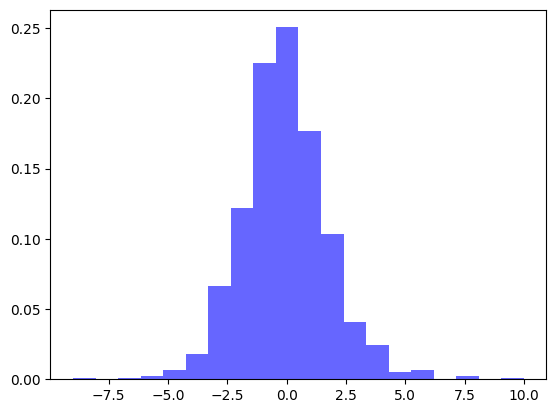

In [ ]:
obs, rewards, dones, infos = sb_env.step_wait()

print(obs.shape)
print(rewards.shape)
print(dones.shape)
print(len(infos))


extracted_infos = [item["terminal_observation"] for item in infos]

df = pd.DataFrame(extracted_infos,columns = ["Cash", "Inventory"])

plt.hist(df["Cash"], bins = 20, density = True, alpha = 0.6, color = 'b')

df.head()

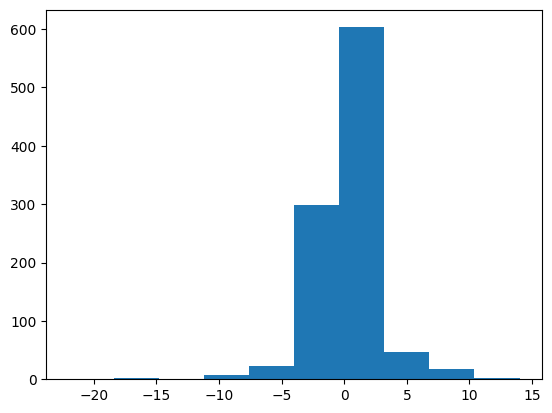

array([0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145,
       0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145,
       0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145,
       0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145,
       0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145,
       0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145,
       0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145,
       0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145,
       0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145,
       0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145,
       0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145,
       0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145,
       0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145,
       0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145, 0.145,
       0.145, 0.145,

In [ ]:
plt.hist(obs[:,0])
plt.show()

obs[:,1]

(array([0.00598591, 0.        , 0.00598591, 0.        , 0.00598591,
        0.02992955, 0.16760548, 5.31548808, 0.05387319, 0.        ,
        0.06584501, 0.03591546, 0.00598591, 0.10774638, 0.00598591,
        0.01197182, 0.04190137, 0.00598591, 0.07183092, 0.04788728]),
 array([-1.26105692, -1.09399795, -0.92693897, -0.75987999, -0.59282102,
        -0.42576204, -0.25870306, -0.09164409,  0.07541489,  0.24247387,
         0.40953284,  0.57659182,  0.7436508 ,  0.91070977,  1.07776875,
         1.24482773,  1.4118867 ,  1.57894568,  1.74600466,  1.91306363,
         2.08012261]),
 <BarContainer object of 20 artists>)

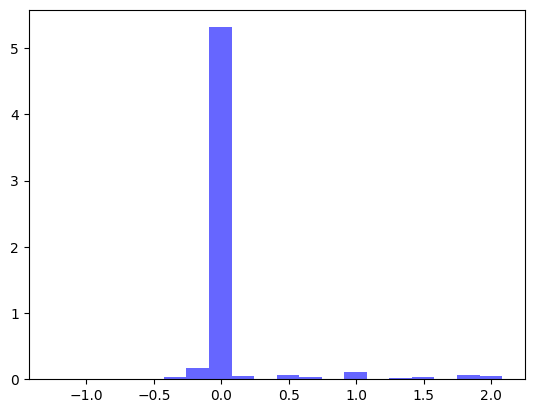

In [ ]:
plt.hist(rewards, bins = 20, density = True, alpha = 0.6, color = 'b')
